In [1]:
from spreg import OLS, vif, OLS_Regimes
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tobler.area_weighted import area_join, area_interpolate
from pysal.explore import esda
import contextily
from sklearn.preprocessing import RobustScaler
from esda.moran import Moran, Moran_Local

/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)
/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/tq

In [167]:
selected = gpd.read_file('../raw_data/infra_model_gdf.shp')

In [3]:
# computing spatial weights
queen = libpysal.weights.Queen.from_dataframe(selected)
inv_dist = libpysal.weights.DistanceBand.from_dataframe(selected, 4300, geom_col='geometry', binary=False)
rook = libpysal.weights.Rook.from_dataframe(selected)

In [4]:
infrastructure = [
        'culture', 'outdoor_fa', 'outdoor_le', 'social_hou',
        'public_hou', 'vegpm20', 'Gymnasium', 'kita', 'stations',
        'extra_edu'
]

In [168]:
y = np.array(selected['child_pov'])
X = selected.drop(columns=[
    'PLR_ID','child_pov', 'geometry']).to_numpy()

In [169]:
robust = RobustScaler()
X = robust.fit_transform(X)

In [170]:
m1 = OLS(y,
        X,
        w=inv_dist,
        name_y='child_pov',
        name_x=infrastructure,
        name_w='dist',
        name_ds='basic_model',
        white_test=True,
        gwk=inv_dist,
        spat_diag=True,
        moran=True)

In [171]:
selected['residuals'] = m1.u

In [172]:
selected.residuals

0     -19.688017
1      -3.633546
2       0.435593
3       6.981902
4      17.408565
         ...    
531   -14.019090
532    -9.762495
533    -2.560691
534     9.063653
535    28.828471
Name: residuals, Length: 536, dtype: float64

In [19]:
import matplotlib as mpl
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))
#here goes residuals column
'''vals = selected.residuals
vmin = min(selected.residuals)
vmax = max(selected.residuals)
norm = MidpointNormalize(vmin=-40, vmax=50, midpoint=0)'''

'vals = selected.residuals\nvmin = min(selected.residuals)\nvmax = max(selected.residuals)\nnorm = MidpointNormalize(vmin=-40, vmax=50, midpoint=0)'

In [188]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  :   child_pov                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          11
S.D. dependent var  :     16.6701                Degrees of Freedom    :         525
R-squared           :      0.3601
Adjusted R-squared  :      0.3479
Sum squared residual:   95140.425                F-statistic           :     29.5401
Sigma-square        :     181.220                Prob(F-statistic)     :   4.571e-45
S.E. of regression  :      13.462                Log likelihood        :   -2148.516
Sigma-square ML     :     177.501                Akaike info criterion :    4319.033
S.E of regression ML:     13.3229                Schwarz criterion     :    4366.158

-----------------------------------------------------------------------------

In [181]:
ols_t = pd.DataFrame(index = infrastructure, columns= {'t_stat' : 0})

In [190]:
ols_t.t_stat = [x[0] for x in m1.t_stat[1:]]

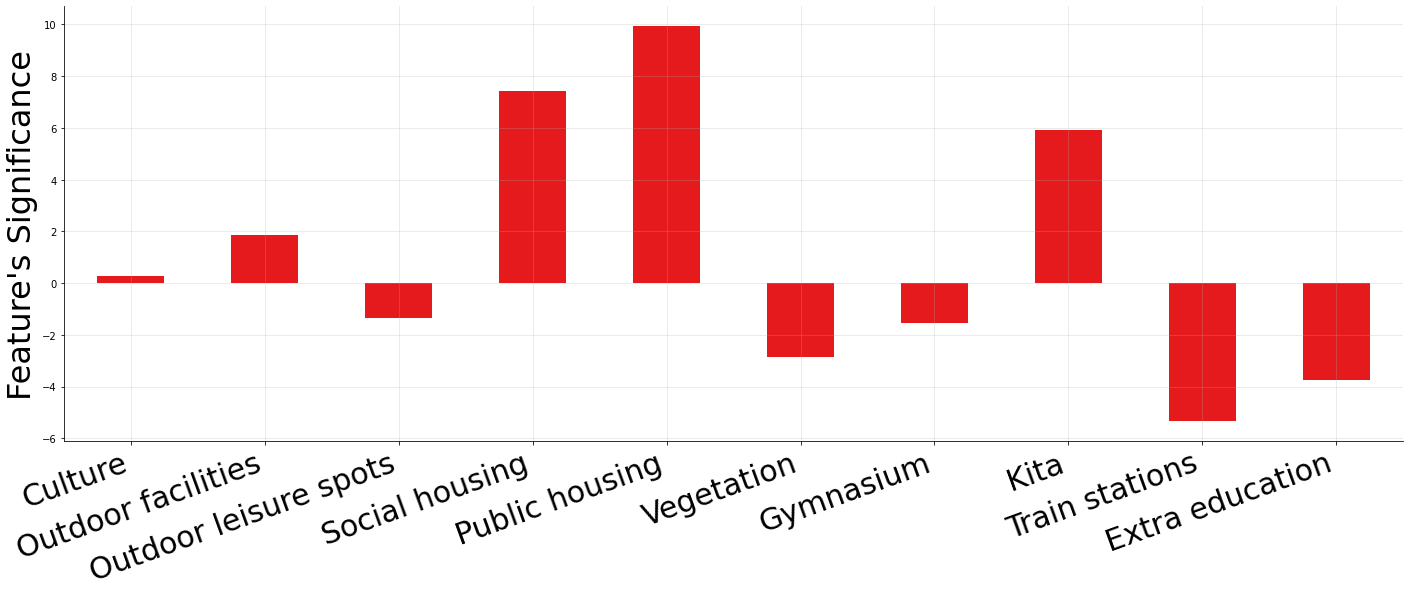

In [206]:
ax = ols_t.plot(figsize=(24, 8), kind='bar', cmap='Set1', legend=False)
ax.set_xticklabels([
    'Culture', 'Outdoor facilities', 'Outdoor leisure spots', 'Social housing',
    'Public housing', 'Vegetation', 'Gymnasium', 'Kita', 'Train stations',
    'Extra education'
],
                   rotation=20,
                   horizontalalignment='right',
                   fontsize=30)
ax.set_ylabel("Feature's Significance", fontsize=32)
ax.spines['right'].set_color(None)
ax.spines['top'].set_color(None)
ax.grid(alpha=0.3)
plt.savefig(fname='plots/t_stat.png',transparent=False, bbox_inches="tight", facecolor='white')

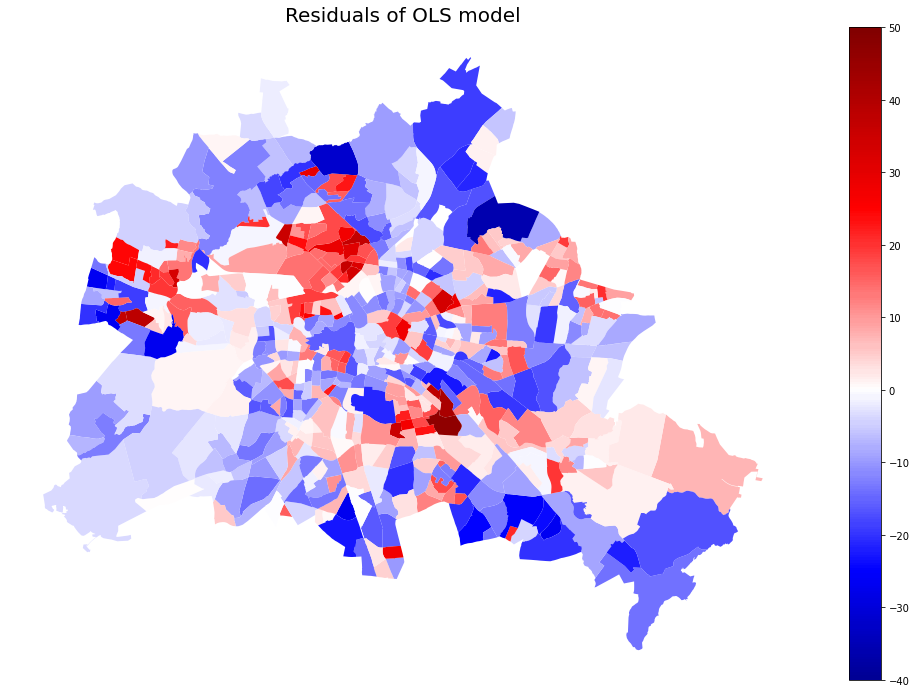

In [174]:
norm = MidpointNormalize(vmin=-40, vmax=50, midpoint=0)
ax = selected.plot(figsize = (18,12), column='residuals', cmap='seismic', norm=norm, legend=True)
ax.axis('off')
ax.set_title('Residuals of OLS model', fontsize=20)
#plt.savefig(fname='plots/ols_residuals.png',transparent=False, bbox_inches="tight", facecolor='white')
plt.show()

In [6]:
from spreg import ML_Lag_Regimes

In [7]:
west = gpd.read_file(
    '../raw_data/more_maps/regimes/Ortsteile__Berlin_West_EPSG54030.shp')
east = gpd.read_file(
    '../raw_data/more_maps/regimes/Ortsteile__Berlin_Ost_EPSG54030.shp')

east.to_crs(crs='EPSG:25833', inplace=True)

west.to_crs(crs='EPSG:25833', inplace=True)

west = west.dissolve()

east = east.dissolve()

eastwest = east.append(west)

eastwest['east'] = eastwest.OBJECTID.map({1: 1, 2: 0})

df_east = selected.sjoin_nearest(eastwest, how='left').dissolve(by='PLR_ID')

df_lag = selected.merge(df_east.reset_index()[['PLR_ID', 'east']], on='PLR_ID')

In [52]:
col = [
        'culture', 'outdoor_fa', 'outdoor_le', 'social_hou',
        'public_hou', 'vegpm20', 'Gymnasium', 'kita', 'stations',
        'extra_edu'
]

In [8]:
y = np.array(df_lag['child_pov'])
X = df_lag[infrastructure].to_numpy()

In [9]:
robust = RobustScaler()
X = robust.fit_transform(X)

In [28]:
mllag_regimes = ML_Lag_Regimes(y,
                               X,
                               regimes=df_lag['east'],
                               name_x=infrastructure,
                               name_y='child poverty',
                               w=inv_dist,
                               name_ds='selected_ds',
                               name_w='inv_dist',
                               method='full',
                               regime_lag_sep=False)

In [29]:
print(mllag_regimes.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG - REGIMES (METHOD = full)
---------------------------------------------------------------------------
Data set            : selected_ds
Weights matrix      :    inv_dist
Dependent Variable  :child poverty                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          23
S.D. dependent var  :     16.6701                Degrees of Freedom    :         513
Pseudo R-squared    :      0.4862
Spatial Pseudo R-squared:  0.3815
Sigma-square ML     :     142.769                Log likelihood        :   -2098.075
S.E of regression   :      11.949                Akaike info criterion :    4242.149
                                                 Schwarz criterion     :    4340.684

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------

In [72]:
west_z = [x[0] for x in mllag_regimes.z_stat][1:11]

In [73]:
east_z = [x[0] for x in mllag_regimes.z_stat][12:-1]

In [128]:
z_pd.index = [
    'Culture', 'Outdoor facilities', 'Outdoor leisure spots', 'Social housing',
    'Public housing', 'Vegetation', 'Gymnasium', 'Kita', 'Train stations', 'Extra education'
]

In [134]:
import matplotlib.patches as mpatches

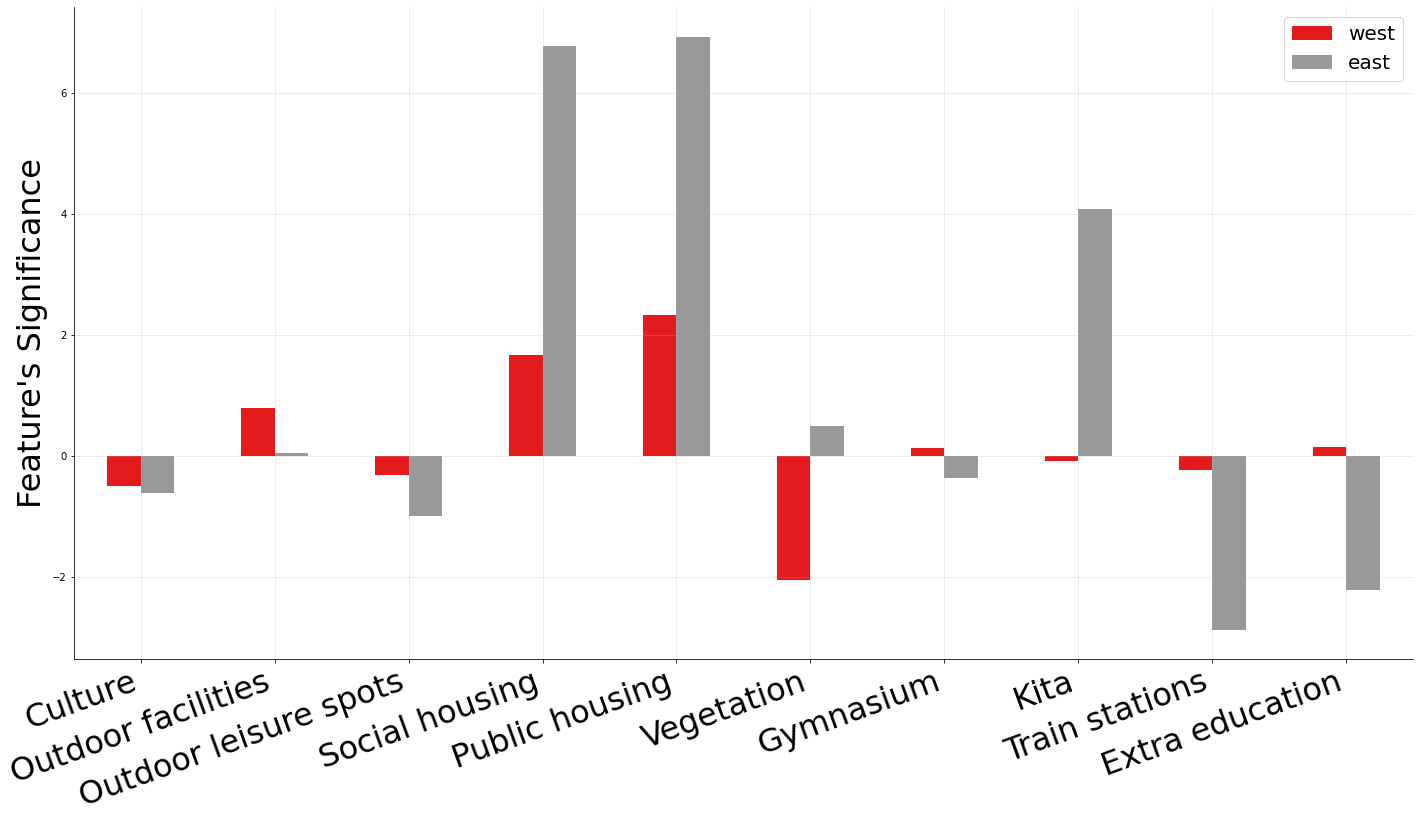

In [210]:
ax = z_pd.plot(figsize=(24, 12), kind='bar', cmap='Set1')
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=20,
                   horizontalalignment='right',
                   fontsize=32)
ax.set_ylabel("Feature's Significance", fontsize=32)
ax.spines['right'].set_color(None)
ax.spines['top'].set_color(None)
ax.legend(fontsize=20)
ax.grid(alpha=0.3)
'''ax.add_patch(mpatches.Rectangle((2.5, 0), 2, 7.1,
             edgecolor = 'blue', facecolor='none',
             fill=True,
             lw=5))'''
plt.savefig(fname='plots/z_stat.png',transparent=False, bbox_inches="tight", facecolor='white')
plt.show()

In [77]:
np.mean(selected['residuals'])

1.715377425510391e-14

In [16]:
df_lag['residuals'] = mllag_regimes.u

In [17]:
df_lag['residuals'].mean()

7.237991300839827e-15

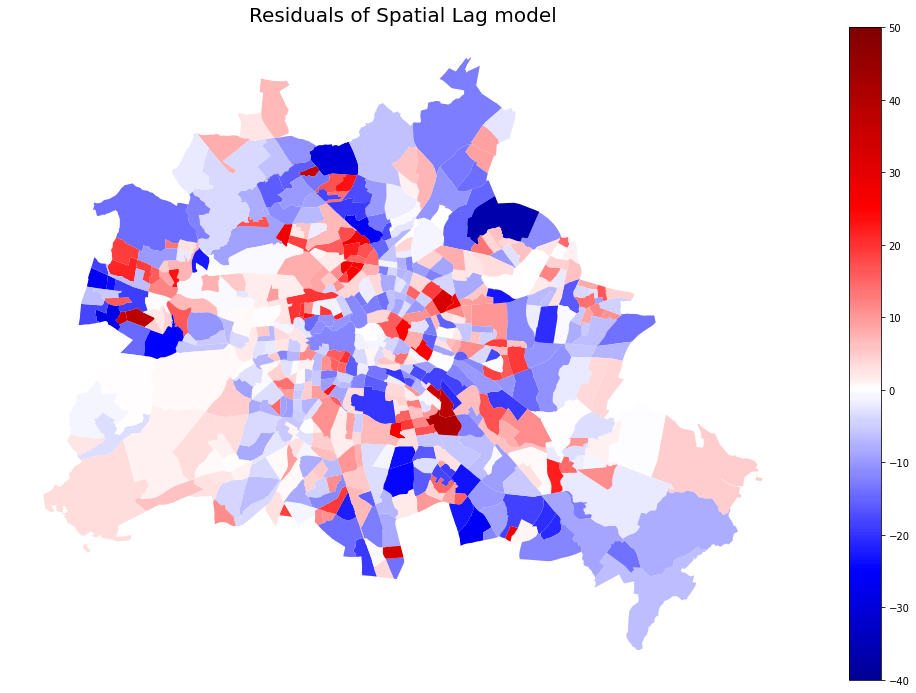

In [20]:
norm = MidpointNormalize(vmin=-40, vmax=50, midpoint=0)
ax = df_lag.plot(figsize = (18,12), column='residuals', cmap='seismic', norm=norm, legend=True)
ax.axis('off')
ax.set_title('Residuals of Spatial Lag model', fontsize=20)
#plt.savefig(fname='plots/mllag_residuals.png',transparent=False, bbox_inches="tight", facecolor='white')
plt.show()

In [78]:
import imageio

In [79]:
from matplotlib import image

In [90]:
ols = image.imread('plots/ols_residuals.png')
lag = image.imread('plots/mllag_residuals.png')

In [91]:
imageio.mimsave(uri='plots/residuals.gif', ims = [ols,lag], fps=0.5)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
